In [145]:
import numpy as np
import pandas as pd
import json
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [12, 8]

In [181]:
def _seq_forward_selection(dataf, ycolumn, xcolumns, test_size, method, seed=99):
    """Sequential forward selection of available features based on holdout performance"""
    
    selected_full, selected_xcolumns = [], []
    while len(xcolumns) != len(selected_xcolumns):
        output_xcolumns, output_scores = [], []
        for f in xcolumns:
            if f not in selected_xcolumns:
                X = dataf[selected_xcolumns + [f]].values
                y = dataf[ycolumn].values
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
                _score = _model(X_train, X_test, y_train, y_test, method, seed=seed)
                output_xcolumns.append(f)
                output_scores.append(_score)
        best_next_score = max(output_scores)
        best_index = output_scores.index(best_next_score)
        best_next_f = output_xcolumns[best_index]
        selected_full.append([len(selected_xcolumns + [best_next_f]), selected_xcolumns + [best_next_f], best_next_score])
        selected_xcolumns.append(best_next_f)

    return selected_full


def _model(X_train, X_test, y_train, y_test, method, seed=99):
    """Fit model and predict on test set"""
    
    if method == 'tree':
        classifier = DecisionTreeClassifier(min_samples_leaf=int(round(len(X_train)*0.01)), random_state=seed)
        classifier.fit(X_train, y_train)
        y_predict = classifier.predict(X_test)
        
    if method == 'svm':
        classifier = LinearSVC(max_iter=100000, dual=True, random_state=seed)
        classifier.fit(X_train, y_train)
        y_predict = classifier.predict(X_test)
        
    if method == 'lg':
        classifier = LogisticRegression(random_state=seed, solver='sag', multi_class='ovr', max_iter=100000)
        classifier.fit(X_train, y_train)
        y_predict = classifier.predict(X_test)
        
    if method == 'randomforest':
        classifier = RandomForestClassifier(n_estimators=100, max_depth=9, random_state=seed)
        classifier.fit(X_train, y_train)
        y_predict = classifier.predict(X_test)
        
    if method == 'boosting':
        params = {
            'n_estimators': 500,
            'max_depth': 4,
            'random_state': 10,
            'min_samples_split': 5,
            'learning_rate': 0.01,
        }
        classifier = GradientBoostingClassifier(**params)
        classifier.fit(X_train, y_train)
        y_predict = classifier.predict(X_test)
    
    return round(metrics.accuracy_score(y_test, y_predict), 7)

def execute_models(models):
    """Loop model execution on forward feature selection"""
    
    model_comparison = {}
    outputdfs = []
    for m in models:
        try:
            print(f'==> running {m}')
            output = _seq_forward_selection(df, ycolumn, xcolumns, test_size, method=m, seed=seed)
            dfoutput = pd.DataFrame(output, columns=['n_features', 'features', 'score'])
            dfoutput.index = dfoutput['n_features']
            outputdfs.append(dfoutput)
            max_score = dfoutput['score'].max()
            optimal_f_selection = dfoutput.loc[lambda x: x['score']==x['score'].max()].loc[lambda x: x['n_features']==x['n_features'].min()]['features'].values[0]
            model_comparison[m] = {
                'score': max_score,
                'n_features': len(optimal_f_selection),
                'features': optimal_f_selection
            }
        except:
            print(f'error occured during {m} model')
            pass
    
    return model_comparison, outputdfs

def tree_fit_score(X_train, y_train, X_test=None, y_test=None, n_nodes=None, use_testset=True, method=None):
    """Fit model on training data, and calculate accuracy based on training or test data"""
    
    if method == 'tree':
        classifier = DecisionTreeClassifier(max_leaf_nodes=n_nodes, random_state=99)
    elif method == 'randomforest':
        classifier = RandomForestClassifier(n_estimators=100, max_leaf_nodes=n_nodes, random_state=seed)
    classifier.fit(X_train, y_train)
    if use_testset == False:
        y_predict = classifier.predict(X_train)
        score = metrics.accuracy_score(y_train, y_predict)
    else:
        y_predict = classifier.predict(X_test)
        score = metrics.accuracy_score(y_test, y_predict)
    return score
    
def n_node_increase_scores(X_train, y_train, X_test, y_test, node_range, method):
    """Get model accuracies for the given n nodes range"""
    
    rows = []
    for n in node_range:
        _score_full = tree_fit_score(X_train, y_train, n_nodes=n, use_testset=False, method=method)
        _score_testtrain = tree_fit_score(X_train, y_train, X_test, y_test, n_nodes=n, method=method)
        rows.append([n, _score_full, _score_testtrain])
        
    return rows

def plot_fitting_graph(rows):
    """Plot n nodes accuracies based on both training and test data"""
    
    plt.plot([y[0] for y in rows], [y[1] for y in rows], label='train_performance', color='k')
    plt.plot([y[0] for y in rows], [y[2] for y in rows], label='test_performance', color='k', linestyle='dashed')
    plt.legend()

### -- modeling and forward feature selection

In [21]:
df = pd.read_csv('input/final_featured_dataset.csv')

In [22]:
ycolumn = 'dealstatus'
xcolumns = [c for c in df.columns if c != ycolumn]
seed = 99
test_size = 0.2
models = ['tree', 'svm', 'lg', 'randomforest', 'boosting']

In [23]:
dealstatuscount = df.groupby(ycolumn)[[xcolumns[1]]].count()
dealstatuscount.columns = ['n_rows']
dealstatuscount['proba'] = round(dealstatuscount['n_rows'] / dealstatuscount['n_rows'].sum(), 2)
dealstatuscount

,n_rows,proba
dealstatus,,
0,351,0.46
1,407,0.54


In [24]:
model_comparison, outputdfs = execute_models(models)

==> running tree
==> running svm
==> running lg
==> running randomforest
==> running boosting


In [25]:
nowstamp = datetime.now().strftime('%Y%m%d%H%M%S')
with open(f'output/model_outputs_{nowstamp}.json', 'w') as stream:
    json.dump(model_comparison, stream)

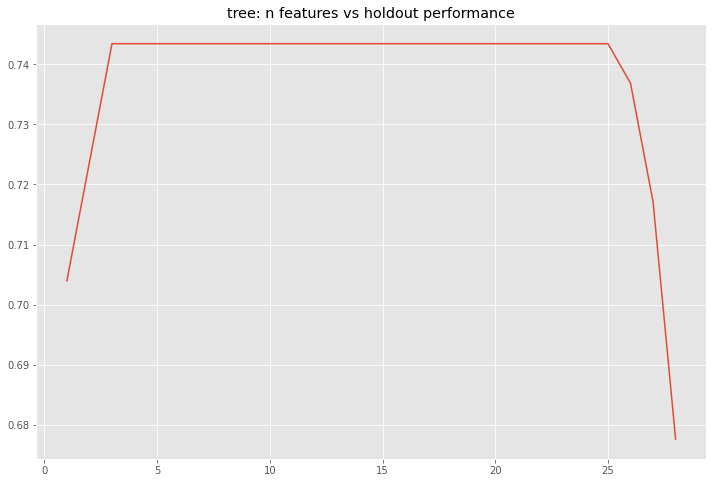

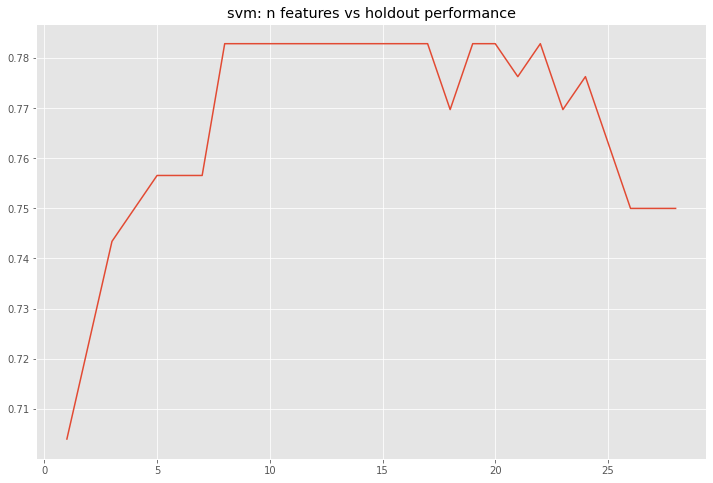

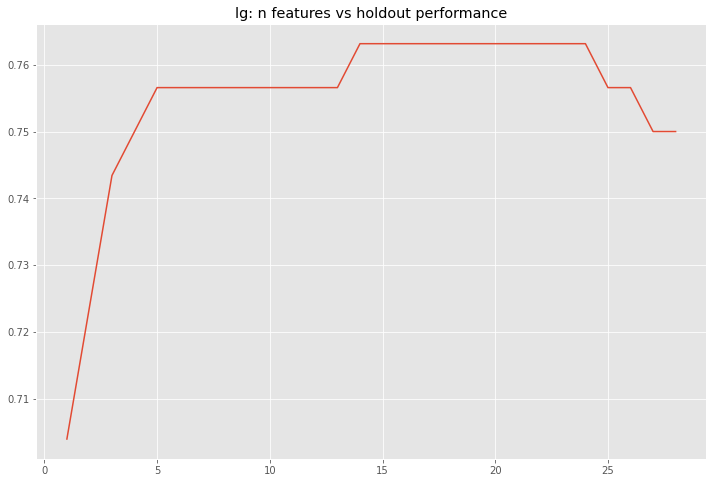

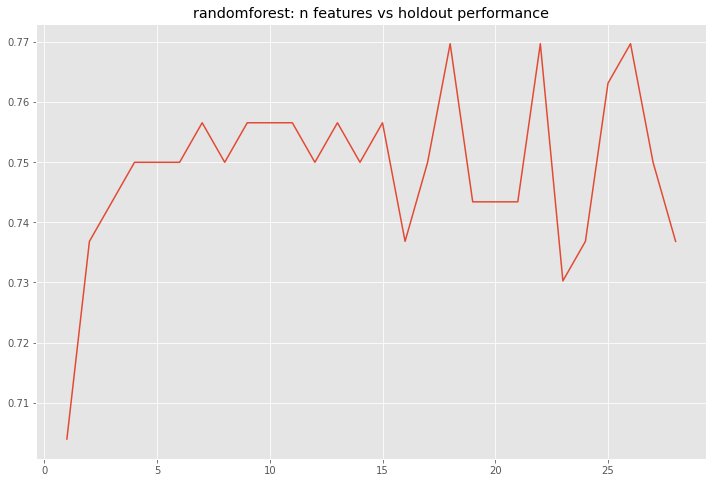

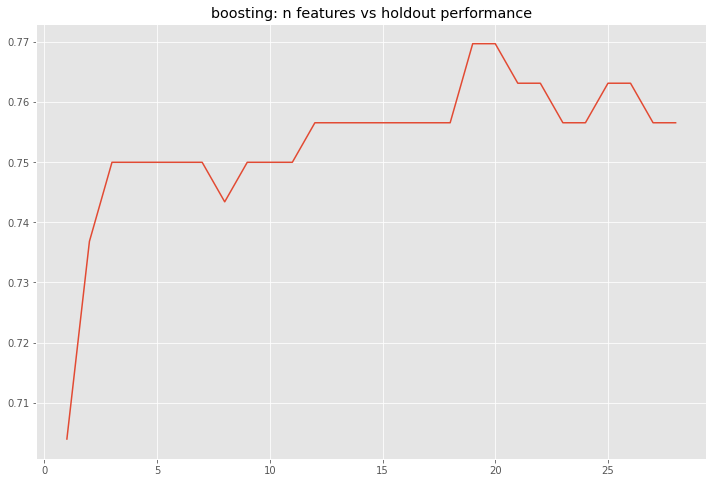

In [26]:
count = 0
for m in models:
    plt.plot(outputdfs[count]['score'])
    plt.title(f'{m}: n features vs holdout performance')
    plt.show()
    count += 1

## -- tree fitting graph

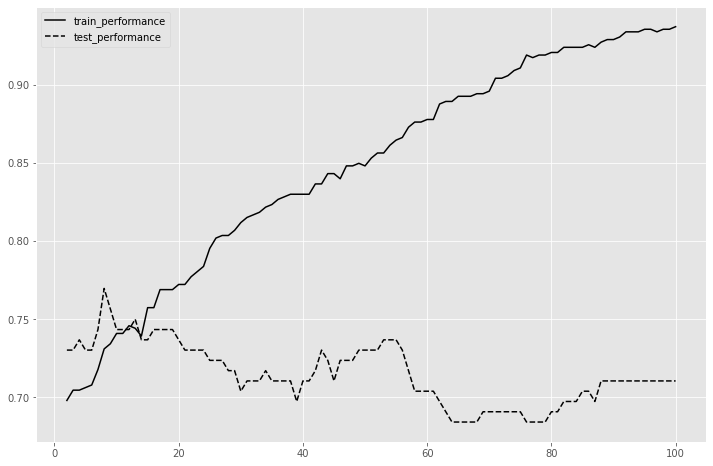

In [182]:
start_n_nodes = 2
end_n_nodes = 100
method = 'randomforest'

X = df[model_comparison[method]['features']].values
y = df[ycolumn].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = n_node_increase_scores(X_train, y_train, X_test, y_test, range(start_n_nodes, end_n_nodes+1), method)
plot_fitting_graph(scores)

## -- model explanation & feature importance

### tree

In [226]:
# model_to_run = 'tree'
model_to_run = 'randomforest'
selected_features = model_comparison[model_to_run]['features']
X = df[selected_features].values
y = df[ycolumn].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
classifier = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=seed)
# classifier = DecisionTreeClassifier(min_samples_leaf=int(round(len(X_train)*0.01)), random_state=seed)
classifier.fit(X_train, y_train)
y_predict = classifier.predict(X_test)
score = round(metrics.accuracy_score(y_test, y_predict), 7)

In [227]:
score

0.7302632

In [228]:
count = 0
for x in df[selected_features].columns:
    print(f'{count}: {x} - min: {df[x].min()}, max: {df[x].max()}')
    count += 1

0: deal_type_acquisition_100% - min: False, max: True
1: roa_target - min: -6602.0, max: 15.774194
2: same_sector - min: False, max: True
3: target_major_sector_textiles - min: False, max: True
4: initial_stake - min: 0.0, max: 44.551
5: target_major_sector_gas - min: False, max: True
6: deal_type_acquisition_other% - min: False, max: True
7: same_country - min: False, max: True
8: target_major_sector_public_administration_and_defence - min: False, max: True
9: target_major_sector_insurance_companies - min: False, max: True
10: target_major_sector_chemicals - min: False, max: True
11: target_major_sector_transport - min: False, max: True
12: target_major_sector_metals_&_metal_products - min: False, max: True
13: target_major_sector_machinery - min: False, max: True
14: target_major_sector_other_services - min: False, max: True
15: target_major_sector_post_and_telecommunications - min: False, max: True
16: target_major_sector_food - min: False, max: True
17: target_major_sector_primary_

[Text(682.3369565217391, 733.86, 'target_major_sector_other_services <= 0.5\ngini = 0.498\nsamples = 384\nvalue = [282, 324]'),
 Text(303.2608695652174, 570.78, 'target_major_sector_post_and_telecommunications <= 0.5\ngini = 0.496\nsamples = 250\nvalue = [211, 176]'),
 Text(181.95652173913044, 407.70000000000005, 'initial_stake <= 41.8\ngini = 0.498\nsamples = 242\nvalue = [198, 175]'),
 Text(121.30434782608695, 244.62, 'target_major_sector_textiles <= 0.5\ngini = 0.498\nsamples = 240\nvalue = [198, 172]'),
 Text(60.65217391304348, 81.54000000000008, 'gini = 0.496\nsamples = 236\nvalue = [198, 166]'),
 Text(181.95652173913044, 81.54000000000008, 'gini = 0.0\nsamples = 4\nvalue = [0, 6]'),
 Text(242.6086956521739, 244.62, 'gini = 0.0\nsamples = 2\nvalue = [0, 3]'),
 Text(424.5652173913043, 407.70000000000005, 'same_country <= 0.5\ngini = 0.133\nsamples = 8\nvalue = [13, 1]'),
 Text(363.9130434782609, 244.62, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(485.2173913043478, 244.62, 'r

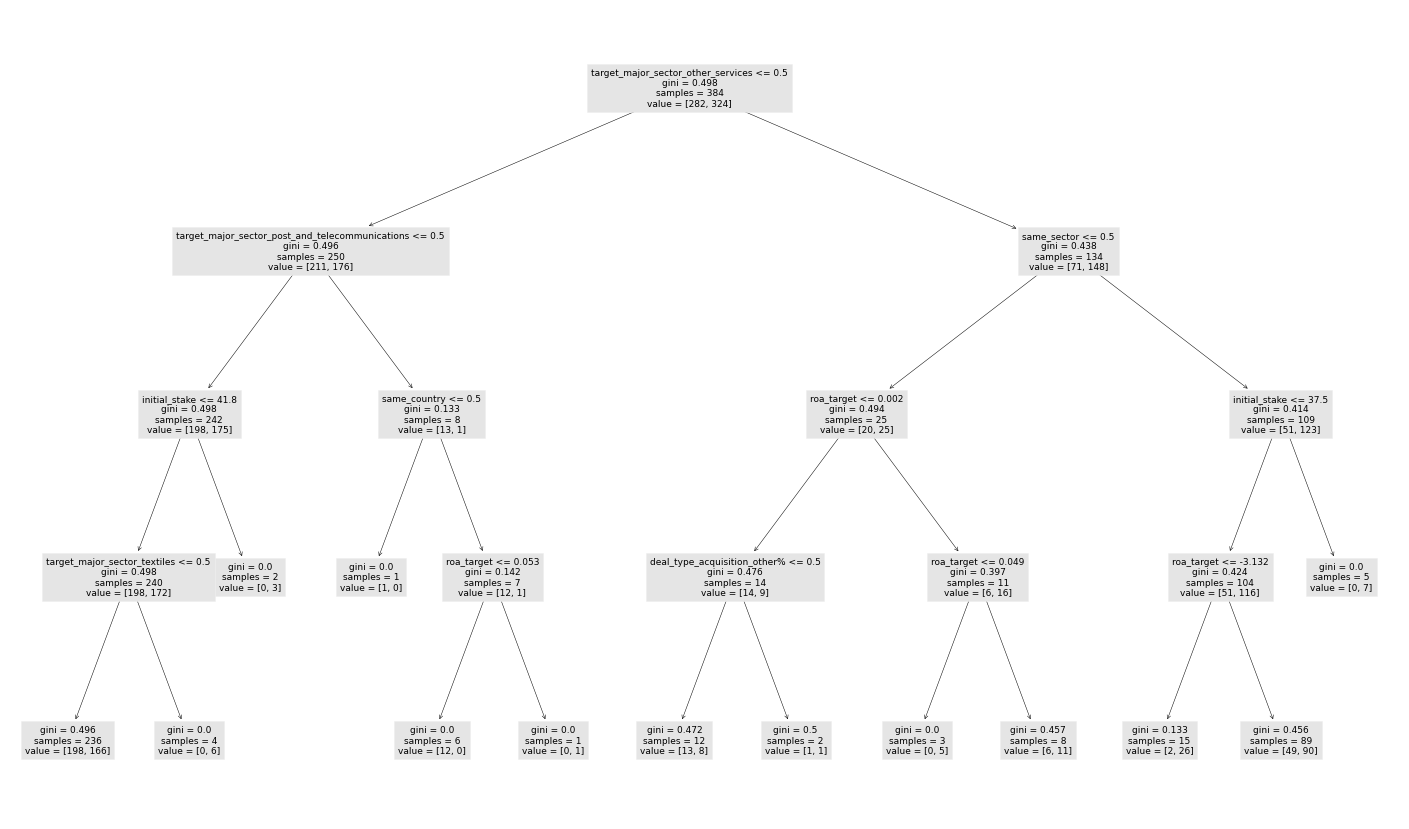

In [235]:
# tree.plot_tree(classifier)
plt.figure(figsize=(25,15))
tree.plot_tree(classifier.estimators_[0], feature_names=selected_features, fontsize=9)

### linear model

In [64]:
model_to_run = 'svm'
selected_features = model_comparison[model_to_run]['features']
X = df[selected_features].values
y = df[ycolumn].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
classifier = LinearSVC(max_iter=100000, dual=True, random_state=seed)
classifier.fit(X_train, y_train)
y_predict = classifier.predict(X_test)
score = round(metrics.accuracy_score(y_test, y_predict), 7)

In [162]:
score

0.7105263

<ipython-input-116-99ceb6b5e250>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(selected_features)


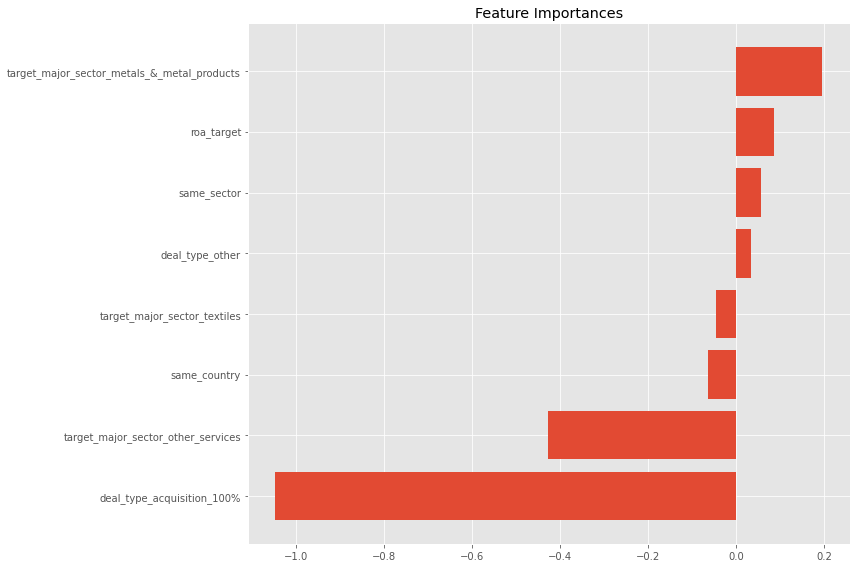

In [116]:
y_ticks = np.arange(0, len(selected_features))
fig, ax = plt.subplots()
ax.barh(y_ticks, sorted(list(classifier.coef_[0]), reverse=False))
ax.set_yticklabels(selected_features)
ax.set_yticks(y_ticks)
ax.set_title("Feature Importances")
fig.tight_layout()
plt.show()